<a href="https://colab.research.google.com/github/kushal-ks/PNM-ML-POC/blob/master/pnm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib import dates
from itertools import chain
import zipfile
import csv
import os
import math

print(tf.__version__)

2.2.0-rc3


In [0]:
local_zip = './pnm_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/')
zip_ref.close()

In [7]:
path = "./data/"
parent_dir_list = os.listdir(path) 
current_date_time = datetime.now()
modem_data = {}
min_date_time = ''
max_date_time = ''
min_mr_lavel = ''
max_mr_lavel = ''
record_id = 0

print(type(min_date_time))
print(parent_dir_list)
for pl_num, pl in enumerate(parent_dir_list):
    modem_list_path = path+"/"+pl
    modem_list_dir = os.listdir(modem_list_path) 
    
    for ml_num, ml in enumerate(modem_list_dir):
      detail_file_path = modem_list_path+"/"+ml
      detail_file_list = os.listdir(detail_file_path)
      record_id = 0
      modem_detail_list = []

      for key in detail_file_list:
          with open(detail_file_path+"/"+str(key)) as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)

            for row in reader:
              record_id += 1
              poll_date = datetime.strptime(str(row[3]), '%Y-%m-%d %H:%M:%S.%f')

              if (pl_num == 0 and ml_num == 0 or poll_date > max_date_time) :
                max_date_time = poll_date
              
              if (pl_num == 0 and ml_num == 0 or poll_date < min_date_time):
                min_date_time = poll_date

              if (pl_num == 0 and ml_num == 0 or float(row[39]) > max_mr_lavel):
                max_mr_lavel = math.ceil(float(row[39]))
              
              if (pl_num == 0 and ml_num == 0 or float(row[39]) < min_mr_lavel):
                min_mr_lavel = math.ceil(float(row[39]))
              
              # day_diff = current_date_time - poll_date;
              modem_detail_list.append({"id": record_id, "mr_lavel": float(row[39]), "poll_time": row[3], "worst_severity": row[len(row) - 1]})
            modem_detail_list.sort(key = lambda x:x['poll_time']) 
            modem_data[ml] = modem_detail_list
day_difference = max_date_time - min_date_time
print(day_difference.days)
print(max_mr_lavel)
print(min_mr_lavel)
print(max_date_time)
print(min_date_time)
print(modem_data)


<class 'str'>
['cmts_2', 'cmts_1']
39
0
-37
2019-08-18 16:00:52.032000
2019-07-10 04:41:20.603000
{'00ace01a00b1': [{'id': 63, 'mr_lavel': -9.199999809265137, 'poll_time': '2019-07-10 04:41:22.994', 'worst_severity': 'immediateActionRequired'}, {'id': 62, 'mr_lavel': -9.390000343322754, 'poll_time': '2019-07-10 04:48:21.823', 'worst_severity': 'immediateActionRequired'}, {'id': 61, 'mr_lavel': -9.489999771118164, 'poll_time': '2019-07-10 04:54:41.935', 'worst_severity': 'immediateActionRequired'}, {'id': 60, 'mr_lavel': -10.039999961853027, 'poll_time': '2019-07-10 13:25:23.381', 'worst_severity': 'immediateActionRequired'}, {'id': 59, 'mr_lavel': -9.319999694824219, 'poll_time': '2019-07-10 13:34:53.245', 'worst_severity': 'immediateActionRequired'}, {'id': 58, 'mr_lavel': -9.220000267028809, 'poll_time': '2019-07-10 15:47:56.422', 'worst_severity': 'immediateActionRequired'}, {'id': 57, 'mr_lavel': -9.229999542236328, 'poll_time': '2019-07-11 05:12:11.761', 'worst_severity': 'immedia

In [0]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)

In [0]:
def configure_chart():
  plt.figure(figsize=(10, 6))
  plt.xlabel("Pool Time")
  plt.ylabel("MR Level")
  plt.xticks(rotation=90)


  # min_date_time_new = min_date_time.strftime('%Y-%m-%d')
  # max_date_time_new = max_date_time.strftime('%Y-%m-%d')
  # print("X level =====>>>>", min_date_time_new)
  # print("Y level =====>>>>", max_date_time_new)
  # plt.axis([min_date_time, max_date_time, min_mr_lavel, max_mr_lavel]) 
  plt.grid(True)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


# New Section

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190], [191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

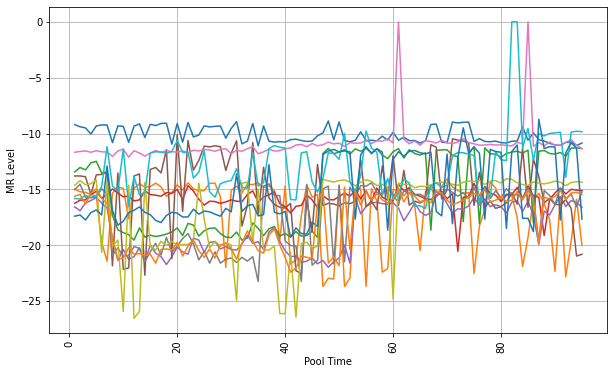

In [12]:
configure_chart()
counter = 0

red_zone_list = []
green_zone_list = []
yellow_zone_list = []
time_list = []

for key in modem_data.keys():
   
  mr_levels = []
  data = modem_data[key]
  red_zone_counter = 0
  green_zone_counter = 0
  yellow_zone_counter = 0
  poll_times = []

  if len(data) == 95:
    for item in data:
      counter = counter + 1
      mr_levels.append(item["mr_lavel"])
      poll_times.append(counter)
      if item["mr_lavel"] > -18:
        red_zone_counter += 1
      elif item["mr_lavel"] > -25 and item["mr_lavel"] <-18:
        yellow_zone_counter += 1
      elif item["mr_lavel"] < -25:
        green_zone_counter += 1
    if red_zone_counter > green_zone_counter and red_zone_counter > yellow_zone_counter:
      red_zone_list.append(mr_levels)
    elif green_zone_counter > yellow_zone_counter:
      green_zone_list.append(mr_levels)
    else:
      yellow_zone_list.append(mr_levels)
    time_list.append(poll_times)
print(time_list)
for x in red_zone_list:
  series = np.array(x)
  time = np.array(time_list[0])
  plot_series(time, series)


In [0]:
x_train = yellow_zone_list[:40]

for red_zone_item in red_zone_list[:6]:
  x_train.append(red_zone_item)

for green_zone_item in green_zone_list[:22]:
  x_train.append(green_zone_item)
  
x_valid = yellow_zone_list[40:]
for red_zone_item in red_zone_list[6:]:
  x_valid.append(red_zone_item)

for green_zone_item in green_zone_list[22:]:
  x_valid.append(green_zone_item)

In [0]:
window_size = 1
batch_size = 1
shuffle_buffer_size = 5

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = np.array(series)
  series = np.squeeze(series)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  
  dataset = dataset.flat_map(lambda window: window.batch(95 + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
def printXValue(x):
  print("X Value ====", x)
  return x

In [60]:
split_time = 95
series_new = green_zone_list[2]
time_train = time_list[0][:split_time]
time_valid = time_list[0][split_time:]
print(time_train)
dataset = windowed_dataset(series_new, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 555.9557 - mae: 23.4831
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 433.2758 - mae: 20.7091
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 322.1884 - mae: 17.8245
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 221.7313 - mae: 14.7324
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 139.1828 - mae: 11.6015
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 79.6357 - mae: 8.6598
Epoch 7/100
94/94 [=============================

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Actual Values===================>>>>>>>>>>>>> [-28.68000031 -29.37999916 -24.62999916 -29.37999916 -24.80999947
 -29.84000015 -29.84000015 -28.95000076 -30.14999962 -24.97999954
 -29.68000031 -30.47999954 -24.62999916 -28.40999985 -29.68000031
 -24.71999931 -30.47999954 -30.64999962 -24.88999939 -24.21999931
 -24.97999954 -29.98999977 -24.80999947 -29.98999977 -24.71999931
 -24.88999939 -24.97999954 -24.97999954 -24.71999931 -30.14999962
 -28.14999962 -24.88999939 -24.97999954 -24.97999954 -29.68000031
 -24.97999954 -29.68000031 -29.84000015 -30.81999969 -28.02000046
 -28.40999985 -27.89999962 -29.68000031 -29.53000069 -

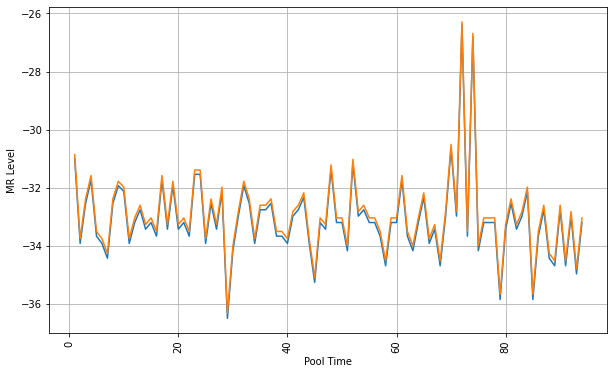

In [66]:
print(time_train)
forecast=[]
series_new = green_zone_list[5]
time_valid = time_list[0]
series_new = np.array(series_new)
for time in range(len(series_new) - window_size):
  forecast.append(model.predict(series_new[time:time + window_size][np.newaxis]))
results = np.array(forecast)[:, 0, 0]

configure_chart()
print("Actual Values===================>>>>>>>>>>>>>", np.array(x_valid))
print("Estimated Values===================>>>>>>>>>>>>>", results)
print("Len==========", len(series_new))
print("Time Valid==========", len(time_valid))
print("Len==========", len(results))
plot_series(time_valid[0:94], series_new[0:94])
plot_series(time_valid[0:94], results)

In [65]:
tf.keras.metrics.mean_squared_error(series_new[0:94], results).numpy()



0.01589918

<Figure size 432x288 with 0 Axes>

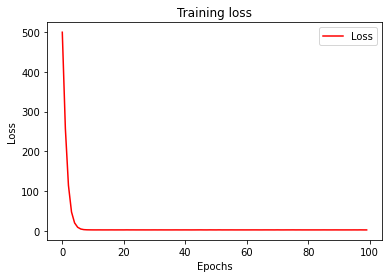

<Figure size 432x288 with 0 Axes>

In [0]:
                                                                  import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()
